In [1]:
import census
import numpy as np
import pandas as pd
import seaborn as sns
import us
import yaml

from matplotlib import cm as cmx
from matplotlib import colors
from matplotlib import pyplot as plt

In [2]:
with open('mycreds.yaml', 'r') as f:
    creds = yaml.safe_load(f)

In [3]:
c = census.Census(creds['api_key'])

In [4]:
data = c.acs5.zipcode(['B01003_001E', 'B06011_001E', 'B02009_001E', 'B03001_003E'], '*')

In [5]:
len(data)

33120

In [6]:
data[0]

{'B01003_001E': 17537.0,
 'B06011_001E': 31603.0,
 'B02009_001E': 273.0,
 'B03001_003E': 1152.0,
 'zip code tabulation area': '01001'}

In [7]:
df = pd.DataFrame.from_records(data)\
    .rename(columns={
        'zip code tabulation area': 'zcta',
        'B01003_001E': 'population',
        'B06011_001E': 'median_income',
        'B02009_001E': 'black_population',
        'B03001_003E': 'hispanic_population'
    })\
    .astype({'population': 'int'})

In [8]:
df.head()

,population,median_income,black_population,hispanic_population,zcta
0,17537,31603.0,273.0,1152.0,01001
1,30280,14855.0,2285.0,1921.0,01002
2,11131,3973.0,815.0,594.0,01003
3,5014,33312.0,118.0,87.0,01005
4,14906,40089.0,123.0,193.0,01007


In [9]:
df['last_digit'] = df.zcta.apply(lambda x: x[-1])
df['log_population'] = df.population.apply(lambda x: np.log(x + 1))
df['log_income'] = df.median_income.apply(lambda x: np.log(x + 1))
df['black_proportion'] = (df.black_population + 1) / (df.population + 1)
df['hispanic_proportion'] = (df.hispanic_population + 1) / (df.population + 1)

In [10]:
digits = np.sort(df.last_digit.unique())

Text(0.5, 1.0, 'Count of ZIP Codes by Last Digit')

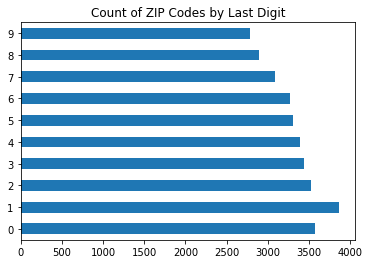

In [11]:
total_counts = df.last_digit.value_counts().sort_index()
total_counts.plot.barh()
plt.title('Count of ZIP Codes by Last Digit')

Text(0.5, 1.0, 'Total population by last digit')

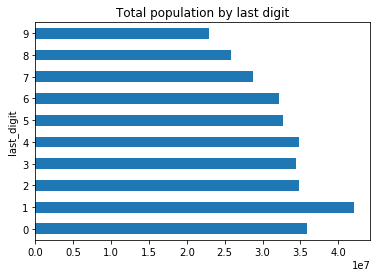

In [12]:
total_pop = df.groupby('last_digit').population.sum().sort_index()
total_pop.plot.barh()
plt.title('Total population by last digit')

Text(0.5, 1.0, 'Mean population by Last Digit')

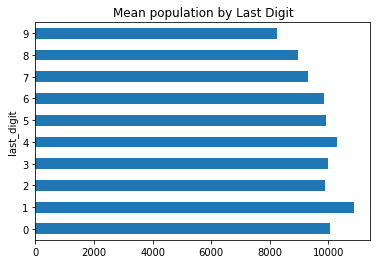

In [13]:
mean_count = total_pop / total_counts
mean_count.plot.barh()
plt.title('Mean population by Last Digit')

Text(0.5, 0.92, 'Log Population by Last Digit')

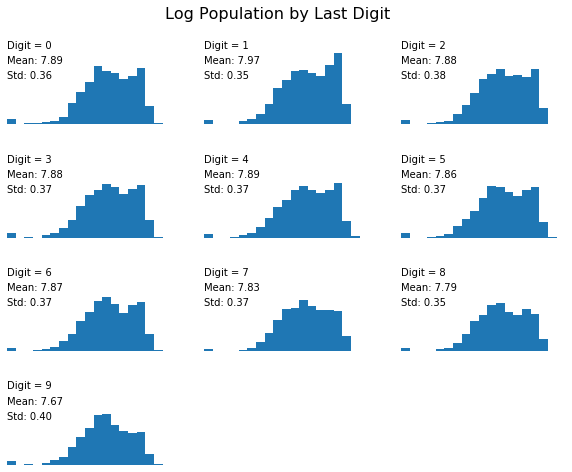

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))

min_x = df.log_population.min()
max_x = df.log_population.max()

for ax, digit in zip(axes.flatten(), digits):
    plt.sca(ax)
    the_filter = df.last_digit == digit
    plt.hist(df.loc[the_filter, 'log_population'], bins=np.linspace(min_x, max_x + 1, 20))
    plt.xlim([min_x, max_x + 1])
    plt.ylim([0, 750])
    plt.text(0, 600, f'Digit = {digit}')
    plt.text(min_x, 480, f"Mean: {df.loc[the_filter, 'log_population'].mean():0.2f}")
    plt.text(min_x, 360, f"Std: {df.loc[the_filter, 'log_income'].std():0.2f}")

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.axis('off')

plt.suptitle('Log Population by Last Digit', y=0.92, fontsize=16)

Text(0.5, 0.92, 'Log Median Income by Last Digit')

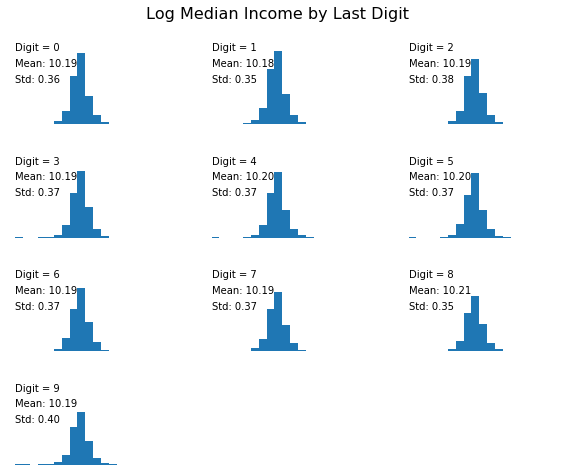

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))

min_x = df.log_income.min()
max_x = df.log_income.max()

is_na_filter = df.median_income.isnull()
for ax, digit in zip(axes.flatten(), digits):
    plt.sca(ax)
    the_filter = df.last_digit == digit
    plt.hist(df.loc[the_filter & ~is_na_filter, 'log_income'], bins=np.linspace(min_x, max_x + 1, 20))
    #plt.xlim([min_x, max_x + 1])
    plt.ylim([0, 1800])
    plt.text(min_x, 1400, f'Digit = {digit}')
    plt.text(min_x, 1100, f"Mean: {df.loc[the_filter & ~is_na_filter, 'log_income'].mean():0.2f}")
    plt.text(min_x, 800, f"Std: {df.loc[the_filter & ~is_na_filter, 'log_income'].std():0.2f}")

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.axis('off')

plt.suptitle('Log Median Income by Last Digit', y=0.92, fontsize=16)
    


Text(0.5, 0.92, 'Black Proportion by Last Digit (log y)')

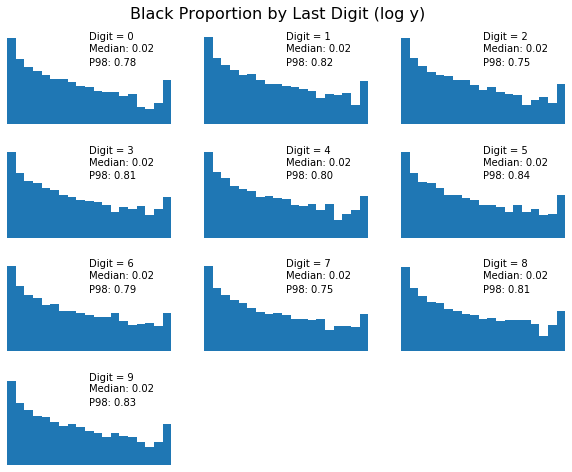

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))

min_x = 0
max_x = 1

is_na_filter = df.median_income.isnull()
for ax, digit in zip(axes.flatten(), digits):
    plt.sca(ax)
    the_filter = df.last_digit == digit
    plt.hist(df.loc[the_filter & ~is_na_filter, 'black_proportion'], bins=np.linspace(min_x, max_x, 20))
    plt.yscale('log')
    plt.xlim([min_x, max_x])
    plt.ylim([1, 5000])
    plt.text(0.5, 2000, f'Digit = {digit}')
    plt.text(0.5, 700, f"Median: {df.loc[the_filter & ~is_na_filter, 'black_proportion'].median():0.2f}")
    plt.text(0.5, 200, f"P98: {df.loc[the_filter & ~is_na_filter, 'black_proportion'].quantile(.98):0.2f}")

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.axis('off')

plt.suptitle('Black Proportion by Last Digit (log y)', y=0.92, fontsize=16)
    


Text(0.5, 0.92, 'Hispanic Proportion by Last Digit (log y)')

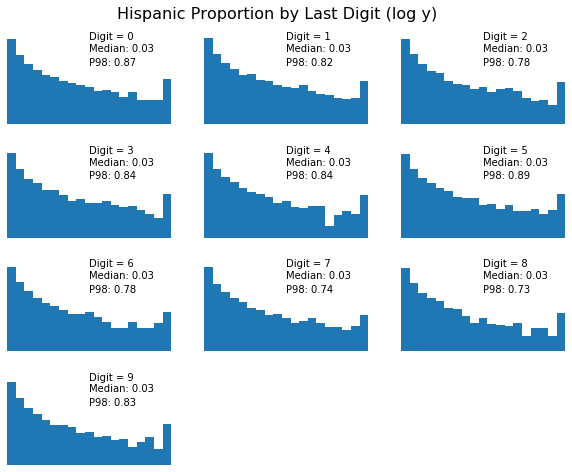

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))

min_x = 0
max_x = 1

is_na_filter = df.median_income.isnull()
for ax, digit in zip(axes.flatten(), digits):
    plt.sca(ax)
    the_filter = df.last_digit == digit
    plt.hist(df.loc[the_filter & ~is_na_filter, 'hispanic_proportion'], bins=np.linspace(min_x, max_x, 20))
    plt.yscale('log')
    plt.xlim([min_x, max_x])
    plt.ylim([1, 5000])
    plt.text(0.5, 2000, f'Digit = {digit}')
    plt.text(0.5, 700, f"Median: {df.loc[the_filter & ~is_na_filter, 'hispanic_proportion'].median():0.2f}")
    plt.text(0.5, 200, f"P98: {df.loc[the_filter & ~is_na_filter, 'hispanic_proportion'].quantile(.98):0.2f}")

for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.axis('off')

plt.suptitle('Hispanic Proportion by Last Digit (log y)', y=0.92, fontsize=16)
    


In [18]:
hot = plt.get_cmap('hot')
df['last_digit'] = df.last_digit.astype(int)
cNorm  = colors.Normalize(vmin=0, vmax=df.last_digit.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)


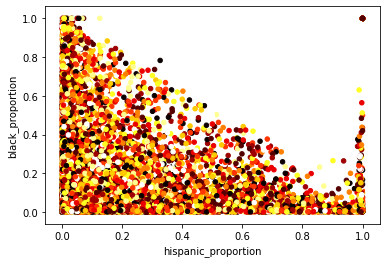

In [19]:
df.plot.scatter('hispanic_proportion', 'black_proportion', c=scalarMap.to_rgba(df.last_digit))